
## Facial landmarks prediction
Goal : to beat the 1.70 RMSE

Doc of Keras is here : https://keras.io/

Play with :
### Regression

 - MaxPooling layer
 - Conv layer (size, number of filters)
 - Dropout
 - Learning rate, optimizer (SGD, Adam)
 - Data augmentation
 
### Predict visibility
 - Predict pose and landmarks jointly (non linear network)
 - Exploiting missing data (predicting visiblity and coordinates) : faces with landmarks not all visible ( coordinate < -1) 
  


In [1]:
import sys
sys.path.append('..')
import alfw
from alfw import Face, lmnames, goodmarksnames, split
import numpy as np
import matplotlib.pyplot as plt
import skimage
%matplotlib inline

from keras.initializations import *
from keras.models import Model
from keras.layers import Dropout, Activation, Flatten, Dense, Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Merge, Reshape, MaxPooling2D
from keras.optimizers import Adam, SGD
from keras.objectives import mean_squared_error
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ProgbarLogger, EarlyStopping
from keras import backend as K
import keras
from theano.sandbox.cuda.dnn import *
import sklearn.metrics
import scipy

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Quadro K5200 (CNMeM is disabled, cuDNN 5005)


ImportError: No module named initializations

In [2]:
Xtrain, ytrain, ht, mm, Xtest, ytest, hts, mmt, (mean, std, meany, stdy, meani, stdi), scale, unscale, d = alfw.prepare(200000, onlyvisible=True)
print 'ytrain ', ytrain.shape    
print Xtrain.shape

print 'mean ', np.mean(Xtrain, axis=3).shape

# to grey
Xtrain = np.mean(Xtrain, axis=3).reshape(Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2], 1)
Xtest = np.mean(Xtest, axis=3).reshape(Xtest.shape[0], Xtest.shape[1], Xtest.shape[2], 1)
Xtest1 = Xtest

# normalize between 0 , 1
Xtrain, ytrain, ht = scale( Xtrain, ytrain, ht )
Xtest, ytest, hts = scale( Xtest, ytest, hts )

loading..
im.shape:  (21776, 128, 128, 3)
feats.shape: (21776, 28, 2)
hogs.shape: (21776, 8100)
goodmarks  (12, 21776, 2)
8166 21776
ytrain.shape  (7349, 12, 2)
ytrain  (7349, 12, 2)
(7349, 128, 128, 3)
mean  (7349, 128, 128)


### a look at data
Y is in [-1 1]

(7349, 128, 128, 1) (817, 128, 128, 1)


(array([  6.30000000e+01,   5.51500000e+03,   4.25140000e+04,
          2.82720000e+04,   2.05530000e+04,   3.04850000e+04,
          2.83770000e+04,   1.87600000e+04,   1.81800000e+03,
          1.90000000e+01]),
 array([-0.875     , -0.69456714, -0.51413428, -0.33370141, -0.15326855,
         0.02716431,  0.20759717,  0.38803004,  0.5684629 ,  0.74889576,
         0.92932862]),
 <a list of 10 Patch objects>)

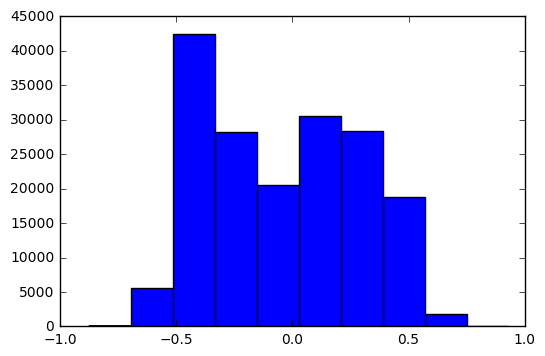

In [5]:
print Xtrain.shape, Xtest.shape
plt.hist(ytrain.flatten())

## Define a simple mlp / cnn with one hidden layer using KERAS

In [6]:
# simple mlp
# input is 2D grey scale
inputs = Input((1, alfw.size, alfw.size))

In [6]:
if False :
    flat = Flatten()(inputs)
    # flatten before feeding to fully connected
    hidden = Dense(400, activation='relu')(flat)
    for i in range(4):
        hidden = Dense(400, activation='relu')(hidden)

In [7]:
conv1 = Convolution2D(10, 5, 5, subsample=(2,2), activation='relu')(inputs)
conv = Convolution2D(10, 3, 3, activation='relu')(conv1)
hidden = Flatten()(conv)

In [8]:
# output
hidden1 = Dense(400, activation='relu')(hidden)
h1 = Dense(ytrain.shape[1]*2)(hidden)
out = Reshape((ytrain.shape[1], 2))(h1)
model = Model(input=inputs, output=out)

In [9]:
# define the optimizer : stochastic gradient descent
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True, decay=1e-6)

In [10]:
model.compile(loss='mean_squared_error', optimizer=sgd)
print model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 1, 128, 128)   0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 10, 62, 62)    260         input_2[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 10, 60, 60)    910         convolution2d_1[0][0]            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 36000)         0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [12]:
history = model.fit(np.transpose(Xtrain, (0, 3, 1, 2)),
                    ytrain,
                    batch_size=128,
                    nb_epoch=20, verbose=2, shuffle=True,
                    validation_split = 0.3)

Train on 5144 samples, validate on 2205 samples
Epoch 1/20
2s - loss: 0.0062 - val_loss: 0.0079
Epoch 2/20
2s - loss: 0.0061 - val_loss: 0.0076
Epoch 3/20
2s - loss: 0.0059 - val_loss: 0.0075
Epoch 4/20
1s - loss: 0.0058 - val_loss: 0.0074
Epoch 5/20
1s - loss: 0.0057 - val_loss: 0.0074
Epoch 6/20
1s - loss: 0.0056 - val_loss: 0.0072
Epoch 7/20
1s - loss: 0.0055 - val_loss: 0.0071
Epoch 8/20
1s - loss: 0.0054 - val_loss: 0.0071
Epoch 9/20
2s - loss: 0.0053 - val_loss: 0.0070
Epoch 10/20
2s - loss: 0.0053 - val_loss: 0.0069
Epoch 11/20
1s - loss: 0.0052 - val_loss: 0.0069
Epoch 12/20
1s - loss: 0.0052 - val_loss: 0.0069
Epoch 13/20
2s - loss: 0.0051 - val_loss: 0.0068
Epoch 14/20
1s - loss: 0.0051 - val_loss: 0.0067
Epoch 15/20
1s - loss: 0.0050 - val_loss: 0.0067
Epoch 16/20
1s - loss: 0.0050 - val_loss: 0.0067
Epoch 17/20
1s - loss: 0.0049 - val_loss: 0.0067
Epoch 18/20
1s - loss: 0.0049 - val_loss: 0.0068
Epoch 19/20
1s - loss: 0.0049 - val_loss: 0.0066
Epoch 20/20
1s - loss: 0.0048 

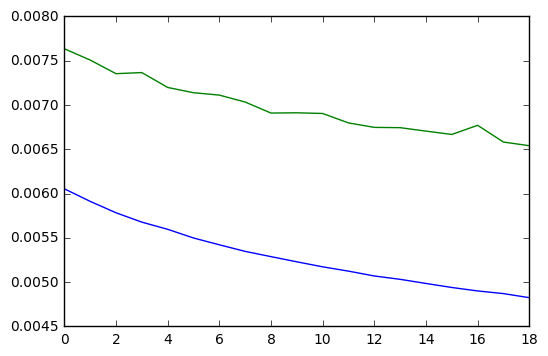

In [13]:
history.history
plt.plot(history.history['loss'][1:], color='blue', label='train')
plt.plot(history.history['val_loss'][1:], color='green' )

(817, 128, 128, 1)
(128, 128) (817, 12, 2)


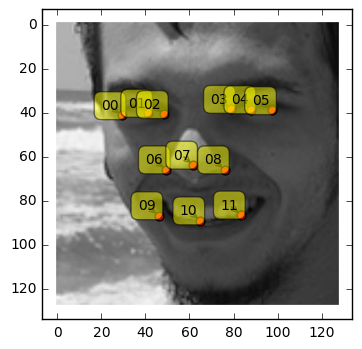

In [14]:
pred = unscale(model.predict(np.transpose(Xtest, (0, 3, 1, 2))))
print Xtest1.shape
exim = Xtest1.reshape(Xtest1.shape[0], Xtest1.shape[1], Xtest1.shape[2])[31,:,:]/255
print exim.shape, pred.shape
alfw.draw(np.dstack((exim, exim, exim)), pred[31, :, :])
#print pred[31,:,:]

rmse =  6.04277577738


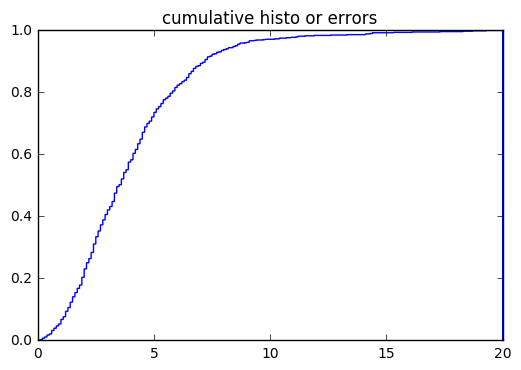

In [15]:

feat=0
predpos = pred[:, feat, :].T
gtpos = unscale(ytest)
gtpos = gtpos[:,feat,:].T
dist = np.linalg.norm(predpos - gtpos, 2, axis=0)
rmse = np.sqrt(np.mean(np.square(dist)))
print 'rmse = ', rmse
#n, bins, patches = plt.hist(dist, 200,)
plt.title('cumulative histo or errors')
n, bins, patches = plt.hist(dist, 200, normed=1,   histtype='step', cumulative=True, range=(0, 20))
